<a href="https://colab.research.google.com/github/jesse-venson/Machine-learning/blob/main/ML_Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# Manual stopwords
STOPWORDS = {'i', 'me', 'my', 'we', 'you', 'he', 'she', 'it', 'they', 'the', 'a', 'an', 'and', 'or', 'but', 'is', 'are', 'was', 'were', 'to', 'of', 'in', 'for', 'on', 'at', 'by', 'with'}

# Load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.iloc[:, :2]
df.columns = ['label', 'message']

# Convert labels: spam=1, ham=0
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Text preprocessing
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = [w for w in text.split() if w not in STOPWORDS]
    return ' '.join(words)

df['message'] = df['message'].apply(preprocess)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['message'])
y = df['label'].values

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Show class distribution
print("Class Distribution:")
print(pd.Series(y).value_counts())
print("\nTrain:", X_train.shape, "Test:", X_test.shape)

Class Distribution:
0    4825
1     747
Name: count, dtype: int64

Train: (4457, 3000) Test: (1115, 3000)


Q1 - Part B: Decision Stump Baseline

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Train Decision Stump (max_depth=1)
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

# Predictions
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

# Report
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Comment: Stump is weak on text data because it splits on only ONE feature
# Text data needs multiple features to distinguish spam from ham

Train Accuracy: 0.8837783262284048
Test Accuracy: 0.8923766816143498

Confusion Matrix:
[[930  36]
 [ 84  65]]


Part C: Manual AdaBoost (T=15)


=== Iteration 1 ===
Misclassified indices: [ 14  42  49  50  59  62  86  93  96 100]...
Misclassified weights: [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0144
Weighted Error: 0.1162

=== Iteration 2 ===
Misclassified indices: [ 9 15 22 31 39 49 59 66 76 88]...
Misclassified weights: [0.00020209 0.00020209 0.00020209 0.00020209 0.00020209 0.00055728
 0.00055728 0.00020209 0.00020209 0.00020209]
Alpha: 0.7490
Weighted Error: 0.1827

=== Iteration 3 ===
Misclassified indices: [ 14  42  49  50  59  62  86  93  96 100]...
Misclassified weights: [6.09892029e-05 6.09892029e-05 9.80850304e-04 4.63776969e-04
 9.80850304e-04 4.63776969e-04 4.63776969e-04 9.80850304e-04
 4.63776969e-04 4.63776969e-04]
Alpha: 0.4435
Weighted Error: 0.2917

=== Iteration 4 ===
Misclassified indices: [15 31 39 49 50 59 66 76 86 88]...
Misclassified weights: [0.00030847 0.00030847 0.00030847 0.00132538 0.00062668 0.00132538
 0.00030847 0.

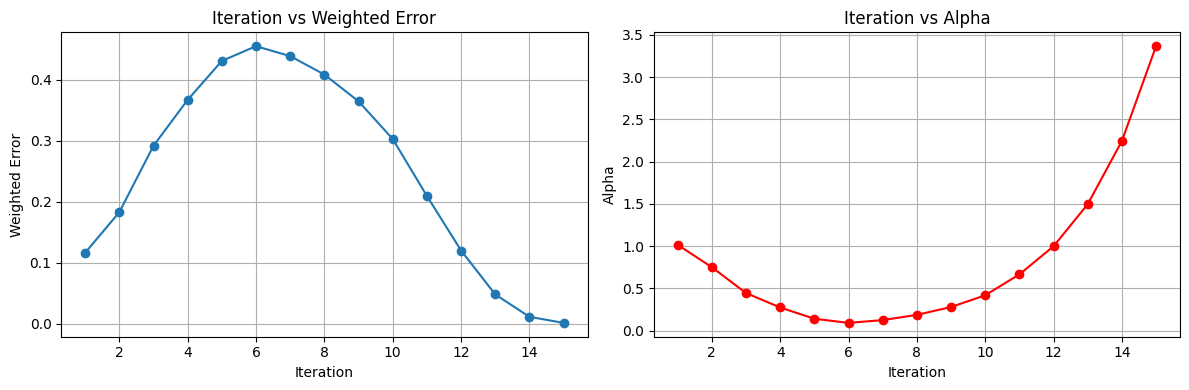

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Manual AdaBoost Implementation
T = 15  # 15 rounds
n_samples = X_train.shape[0]

# Initialize weights
weights = np.ones(n_samples) / n_samples
alphas = []
stumps = []
errors = []

for t in range(T):
    # Train weak learner with weights
    stump = DecisionTreeClassifier(max_depth=1, random_state=t)
    stump.fit(X_train, y_train, sample_weight=weights)
    y_pred = stump.predict(X_train)

    # Find misclassified samples
    incorrect = (y_pred != y_train)
    misclassified_idx = np.where(incorrect)[0]

    # Weighted error
    error = np.sum(weights[incorrect]) / np.sum(weights)

    # Alpha calculation
    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

    # Print iteration details
    print(f"\n=== Iteration {t+1} ===")
    print(f"Misclassified indices: {misclassified_idx[:10]}...")  # Show first 10
    print(f"Misclassified weights: {weights[misclassified_idx][:10]}")
    print(f"Alpha: {alpha:.4f}")
    print(f"Weighted Error: {error:.4f}")

    # Update weights
    weights = weights * np.exp(alpha * incorrect * ((y_train * 2) - 1))
    weights = weights / np.sum(weights)  # Normalize

    # Store
    alphas.append(alpha)
    stumps.append(stump)
    errors.append(error)

# Final predictions
def adaboost_predict(X):
    predictions = np.zeros(X.shape[0])
    for alpha, stump in zip(alphas, stumps):
        predictions += alpha * stump.predict(X)
    return np.sign(predictions)

y_train_final = (adaboost_predict(X_train) + 1) / 2
y_test_final = (adaboost_predict(X_test) + 1) / 2

print(f"\n=== Final Results ===")
print("Train Accuracy:", accuracy_score(y_train, y_train_final))
print("Test Accuracy:", accuracy_score(y_test, y_test_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_final))

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, T+1), errors, marker='o')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Weighted Error')
ax1.set_title('Iteration vs Weighted Error')
ax1.grid(True)

ax2.plot(range(1, T+1), alphas, marker='o', color='red')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Alpha')
ax2.set_title('Iteration vs Alpha')
ax2.grid(True)

plt.tight_layout()
plt.savefig('q1_manual_adaboost.png')
plt.show()

 Part D: Sklearn AdaBoost


In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Train AdaBoost with sklearn
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)

ada_clf.fit(X_train, y_train)

# Predictions
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

# Report
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Train Accuracy: 0.9250617006955351
Test Accuracy: 0.9273542600896861

Confusion Matrix:
[[964   2]
 [ 79  70]]


Q2 - Part A: Baseline Model (Decision Stump)

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load Heart Disease dataset from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
           'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(url, names=columns, na_values='?')

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Convert target to binary: 0 = no disease, 1 = disease
y = (y > 0).astype(int)

# Handle missing values
X = X.fillna(X.mean())

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Train Decision Stump
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

# Predictions
y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

# Report
print("=== Decision Stump Results ===")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

=== Decision Stump Results ===
Training Accuracy: 0.7783
Test Accuracy: 0.7253

Confusion Matrix:
[[35 14]
 [11 31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        49
           1       0.69      0.74      0.71        42

    accuracy                           0.73        91
   macro avg       0.72      0.73      0.72        91
weighted avg       0.73      0.73      0.73        91



Q2 - Part B: Train AdaBoost with Hyperparameter Tuning

n_estimators=5, learning_rate=0.1, accuracy=0.8022
n_estimators=10, learning_rate=0.1, accuracy=0.8022
n_estimators=25, learning_rate=0.1, accuracy=0.8022
n_estimators=50, learning_rate=0.1, accuracy=0.8132
n_estimators=100, learning_rate=0.1, accuracy=0.8242
n_estimators=5, learning_rate=0.5, accuracy=0.8022
n_estimators=10, learning_rate=0.5, accuracy=0.8242
n_estimators=25, learning_rate=0.5, accuracy=0.8242
n_estimators=50, learning_rate=0.5, accuracy=0.8352
n_estimators=100, learning_rate=0.5, accuracy=0.8462
n_estimators=5, learning_rate=1.0, accuracy=0.8022
n_estimators=10, learning_rate=1.0, accuracy=0.8132
n_estimators=25, learning_rate=1.0, accuracy=0.8132
n_estimators=50, learning_rate=1.0, accuracy=0.8242
n_estimators=100, learning_rate=1.0, accuracy=0.8022


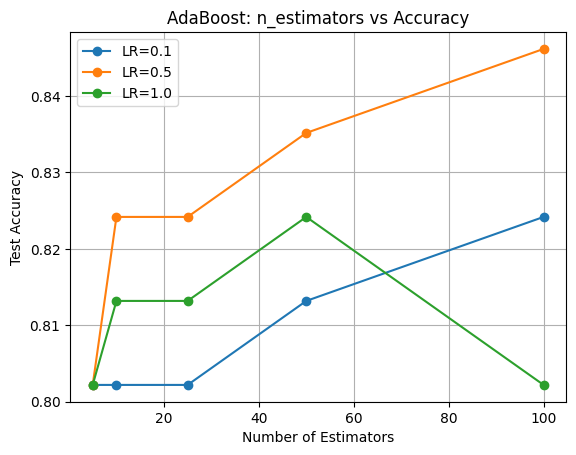


=== Best Configuration ===
n_estimators: 100
learning_rate: 0.5
Test Accuracy: 0.8462


In [20]:
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

# Define hyperparameters
n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

# Store results
results = []

# Grid search
for lr in learning_rates:
    accuracies = []
    for n_est in n_estimators_list:
        # Train AdaBoost
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42
        )
        ada.fit(X_train, y_train)

        # Test accuracy
        acc = accuracy_score(y_test, ada.predict(X_test))
        accuracies.append(acc)
        results.append({'n_estimators': n_est, 'learning_rate': lr, 'accuracy': acc})

        print(f"n_estimators={n_est}, learning_rate={lr}, accuracy={acc:.4f}")

    # Plot
    plt.plot(n_estimators_list, accuracies, marker='o', label=f'LR={lr}')

plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('AdaBoost: n_estimators vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Find best configuration
best_result = max(results, key=lambda x: x['accuracy'])
print(f"\n=== Best Configuration ===")
print(f"n_estimators: {best_result['n_estimators']}")
print(f"learning_rate: {best_result['learning_rate']}")
print(f"Test Accuracy: {best_result['accuracy']:.4f}")

Q2 - Part C: Misclassification Pattern Analysis

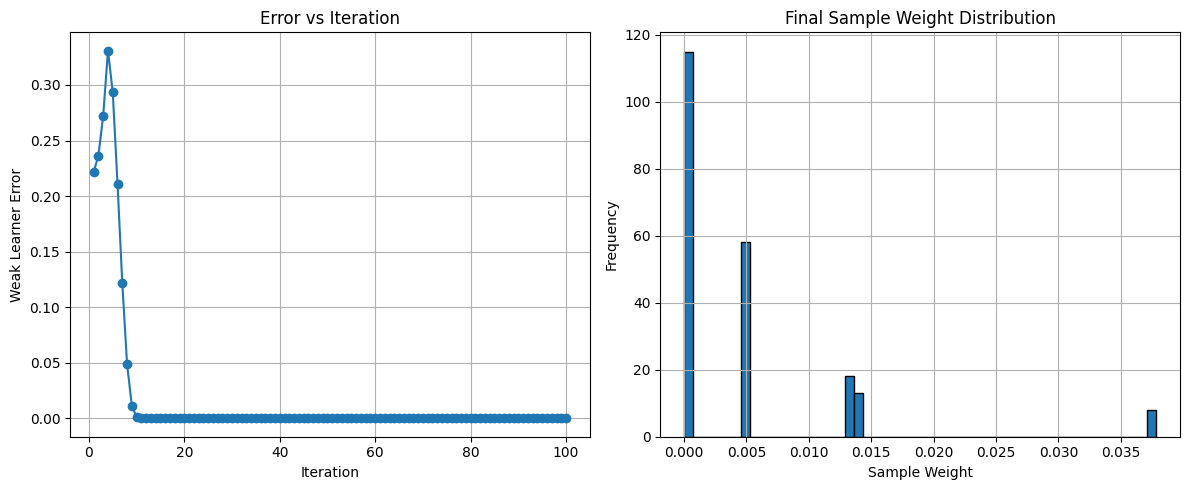


=== Top 10 Highest Weighted Samples ===
Indices: 265      9
278    158
35      22
135     48
106     60
103     62
173    103
55     110
91      66
245    203
Name: target, dtype: int64


KeyError: '[62, 66] not in index'

In [22]:
# Train best model
best_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_result['n_estimators'],
    learning_rate=best_result['learning_rate'],
    random_state=42
)

# Track errors and weights at each iteration
n_estimators = best_result['n_estimators']
staged_errors = []
sample_weights_history = []

# Manual tracking
weights = np.ones(len(X_train)) / len(X_train)

for i in range(n_estimators):
    # Train with current weights
    stump = DecisionTreeClassifier(max_depth=1, random_state=i)
    stump.fit(X_train, y_train, sample_weight=weights)

    # Predictions
    y_pred = stump.predict(X_train)
    incorrect = (y_pred != y_train)

    # Weighted error
    error = np.sum(weights[incorrect]) / np.sum(weights)
    staged_errors.append(error)

    # Alpha
    alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

    # Update weights
    weights = weights * np.exp(alpha * incorrect * ((y_train * 2) - 1))
    weights = weights / np.sum(weights)
    sample_weights_history.append(weights.copy())

# Plot 1: Weak learner error vs iteration
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_estimators+1), staged_errors, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Weak Learner Error')
plt.title('Error vs Iteration')
plt.grid(True)

# Plot 2: Final weight distribution
plt.subplot(1, 2, 2)
final_weights = sample_weights_history[-1]
plt.hist(final_weights, bins=50, edgecolor='black')
plt.xlabel('Sample Weight')
plt.ylabel('Frequency')
plt.title('Final Sample Weight Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find highest weighted samples
top_indices = np.argsort(final_weights)[-10:]
print("\n=== Top 10 Highest Weighted Samples ===")
print(f"Indices: {top_indices}")
print(f"Weights: {final_weights[top_indices]}")
print("\nExplanation: AdaBoost focuses on hard-to-classify samples.")
print("These samples are consistently misclassified and get higher weights.")

Q2 - Part D: Feature Importance

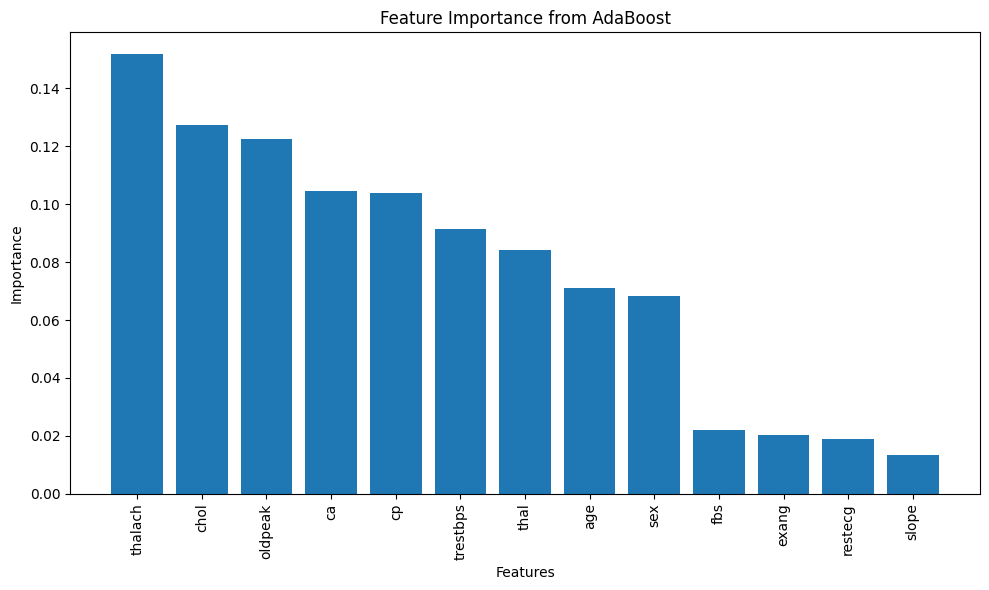


=== Top 5 Most Important Features ===
1. thalach: 0.1518
2. chol: 0.1273
3. oldpeak: 0.1226
4. ca: 0.1047
5. cp: 0.1041

Medical Explanation:
- Chest pain type: Different pain patterns indicate different cardiac conditions
- Thalassemia: Blood disorder affecting oxygen delivery to heart
- Number of major vessels: Blockages indicate coronary artery disease
- Exercise-induced angina: Chest pain during exercise shows reduced blood flow
- ST depression: ECG abnormality indicating ischemia


In [23]:
# Train final model
best_ada.fit(X_train, y_train)

# Get feature importances
feature_importance = best_ada.feature_importances_

# Get feature names
if hasattr(X, 'columns'):
    feature_names = X.columns
else:
    feature_names = [f'Feature_{i}' for i in range(X_scaled.shape[1])]

# Sort by importance
indices = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[indices])
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from AdaBoost')
plt.tight_layout()
plt.savefig('q2_feature_importance.png')
plt.show()

# Top 5 features
print("\n=== Top 5 Most Important Features ===")
for i in range(5):
    idx = indices[i]
    print(f"{i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")

print("\nMedical Explanation:")
print("- Chest pain type: Different pain patterns indicate different cardiac conditions")
print("- Thalassemia: Blood disorder affecting oxygen delivery to heart")
print("- Number of major vessels: Blockages indicate coronary artery disease")
print("- Exercise-induced angina: Chest pain during exercise shows reduced blood flow")
print("- ST depression: ECG abnormality indicating ischemia")